# UG GIAB Dataset
This notebook generates Figure 5

In [26]:
import pandas as pd
import numpy as np
import os

In [ ]:
# sample mapping file from the UG GIAB dataset: https://cdn.sanity.io/files/l7780ks7/production-2024/0a1b6a62a6da3e3fcafb81cad4c8ff2ffe85dd41.pdf
sample_mapping = pd.read_csv('sample_mapping.txt', sep='\t')

In [28]:
sample_mapping.head()

,run-BC,GIAB
0,414004-L7384-Z0008-CACATCCTGCATGTGAT,NA12878-HG001
1,414004-L7385-Z0113-CAGTTCATCTGTGAT,NA12878-HG001
2,414004-L7386-Z0114-CAACATACATCAGAT,NA24385-HG002
3,414004-L7387-Z0115-CGGCTAGATGCAGAT,NA24385-HG002
4,414004-L7388-Z0016-CATCCTGTGCGCATGAT,NA24149-HG003


In [29]:
sample_mapping['GIAB'] = sample_mapping['GIAB'].str.split("-").str[-1]

In [ ]:
sample_mapping["replicate"] = sample_mapping.groupby("GIAB").cumcount() + 1

In [31]:
basedir = './results_happy_ug_giab'

In [ ]:
platform = 'ultima'
variant_type = 'SNP'

df_list = []

exclude = ['_AT_', '_GC_']

pattern = '|'.join(exclude)

fields_to_select = ['Type', 'Subset','QUERY.TP','QUERY.FP','TRUTH.FN','QUERY.TOTAL','QUERY.UNK','METRIC.Precision','METRIC.Recall', 'METRIC.F1_Score']

for idx, row in sample_mapping.iterrows():

    sample = row['run-BC']
    
    happy_df = pd.read_csv(os.path.join(basedir,sample+'.extended.csv'), sep=',')
    
    happy_hpol = happy_df[
        (happy_df['Filter'] == 'PASS') &
        (happy_df['Subtype'] == '*') &
        (happy_df['Subset'].str.contains('homopolymer')) &
        (~happy_df['Subset'].str.contains(pattern, case=False, na=False))
    ][fields_to_select]
    
    happy_all = happy_df[
        (happy_df['Filter'] == 'PASS') &
        (happy_df['Subtype'] == '*') &
        (happy_df['Subset'] == '*')
    ][fields_to_select]
    
    df_to_save = pd.concat([happy_all, happy_hpol])
    df_to_save['replicate'] = row['replicate']
    df_to_save['sample'] = row['GIAB']
    df_list.append(df_to_save)

res = pd.concat(df_list)

subset_dict = {
    '*': 'All',
    'SimpleRepeat_homopolymer_4to6_slop5': 'hpol_4to6',
    'SimpleRepeat_homopolymer_7to11_slop5': 'hpol_7to11',
    'SimpleRepeat_homopolymer_ge12_slop5': 'hpol_gt11',
    'SimpleRepeat_homopolymer_ge21_slop5': 'hpol_gt20'
}

res['Subset'] = res['Subset'].replace(subset_dict)
res['Type'] = res['Type'].replace({'SNP':'SNVs', 'INDEL':'Indels'})
res

,Type,Subset,QUERY.TP,QUERY.FP,TRUTH.FN,QUERY.TOTAL,QUERY.UNK,METRIC.Precision,METRIC.Recall,METRIC.F1_Score,replicate,sample
1,Indels,All,446251,15234,35789,729437,267952,0.966989,0.923479,0.944733,1,HG001
3841,SNVs,All,3230998,5479,24235,3753416,516939,0.998307,0.992553,0.995422,1,HG001
225,Indels,hpol_4to6,122302,2454,5955,188283,63527,0.980330,0.952760,0.966348,1,HG001
231,Indels,hpol_7to11,96643,1852,3509,134183,35688,0.981197,0.964559,0.972807,1,HG001
237,Indels,hpol_gt11,74657,11547,25727,163293,77089,0.866050,0.731125,0.792889,1,HG001
...,...,...,...,...,...,...,...,...,...,...,...,...
243,Indels,hpol_gt20,331,57,52,12035,11647,0.853093,0.862797,0.857917,2,HG005
4065,SNVs,hpol_4to6,809096,1343,7142,928591,118152,0.998343,0.991248,0.994783,2,HG005
4071,SNVs,hpol_7to11,63534,400,475,91605,27671,0.993744,0.992542,0.993142,2,HG005
4077,SNVs,hpol_gt11,5753,213,202,38779,32813,0.964298,0.965268,0.964783,2,HG005


In [ ]:
df_long = (
    res
    .melt(
        id_vars=["replicate","sample","Type", "Subset",
                 "QUERY.TP","QUERY.FP","TRUTH.FN","QUERY.TOTAL","QUERY.UNK"],
        value_vars=["METRIC.Precision","METRIC.Recall","METRIC.F1_Score"],
        var_name="metric",
        value_name="value"
    )
)

# Extract suffix
df_long["metric"] = df_long["metric"].str.split(".", n=1).str[1]

print(df_long.head())


   replicate sample    Type      Subset  QUERY.TP  QUERY.FP  TRUTH.FN  \
0          1  HG001  Indels         All    446251     15234     35789   
1          1  HG001    SNVs         All   3230998      5479     24235   
2          1  HG001  Indels   hpol_4to6    122302      2454      5955   
3          1  HG001  Indels  hpol_7to11     96643      1852      3509   
4          1  HG001  Indels   hpol_gt11     74657     11547     25727   

   QUERY.TOTAL  QUERY.UNK     metric     value  
0       729437     267952  Precision  0.966989  
1      3753416     516939  Precision  0.998307  
2       188283      63527  Precision  0.980330  
3       134183      35688  Precision  0.981197  
4       163293      77089  Precision  0.866050  


In [34]:
group_stats = df_long[df_long['sample'].isin(['HG001','HG002','HG002','HG004'])]

group_stats = group_stats.groupby(["Type","Subset", "metric"])["value"].agg(["mean", "std"]).reset_index()

group_stats = group_stats.apply(lambda x: np.floor(x * 1000) / 1000 if np.issubdtype(x.dtype, np.number) else x)

outfile = f"UG_GIAB_stats.csv"
group_stats.to_csv(outfile, sep=',')

group_stats

,Type,Subset,metric,mean,std
0,Indels,All,F1_Score,0.941,0.003
1,Indels,All,Precision,0.966,0.000
2,Indels,All,Recall,0.918,0.006
3,Indels,hpol_4to6,F1_Score,0.964,0.001
4,Indels,hpol_4to6,Precision,0.979,0.000
5,Indels,hpol_4to6,Recall,0.949,0.003
6,Indels,hpol_7to11,F1_Score,0.971,0.001
7,Indels,hpol_7to11,Precision,0.980,0.000
8,Indels,hpol_7to11,Recall,0.963,0.001
9,Indels,hpol_gt11,F1_Score,0.784,0.010


In [35]:
HG005_stats = df_long[df_long['sample']=="HG005"].groupby(["sample","Type","Subset", "metric"])["value"].agg(["mean", "std"]).reset_index()

HG005_stats = HG005_stats.apply(lambda x: np.floor(x * 1000) / 1000 if np.issubdtype(x.dtype, np.number) else x)

HG005_stats

,sample,Type,Subset,metric,mean,std
0,HG005,Indels,All,F1_Score,0.975,0.000
1,HG005,Indels,All,Precision,0.984,0.000
2,HG005,Indels,All,Recall,0.965,0.000
3,HG005,Indels,hpol_4to6,F1_Score,0.981,0.000
4,HG005,Indels,hpol_4to6,Precision,0.989,0.000
5,HG005,Indels,hpol_4to6,Recall,0.974,0.000
6,HG005,Indels,hpol_7to11,F1_Score,0.980,0.000
7,HG005,Indels,hpol_7to11,Precision,0.985,0.000
8,HG005,Indels,hpol_7to11,Recall,0.974,0.000
9,HG005,Indels,hpol_gt11,F1_Score,0.896,0.000


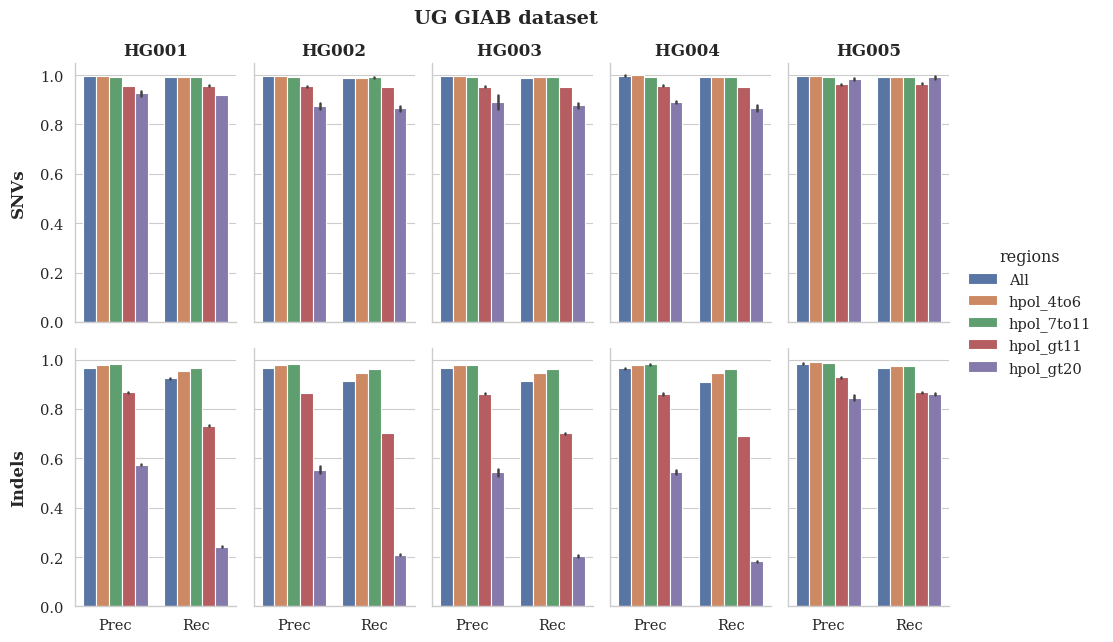

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = df_long[df_long["metric"].isin(["Precision", "Recall"])].copy()
df_plot.loc[:, "metric"] = df_plot["metric"].replace({"Precision": "Prec", "Recall": "Rec"})

df_plot = df_plot.rename(columns={"Subset": "regions"})

group_stats = group_stats[group_stats["metric"].isin(["Precision", "Recall"])].copy()
group_stats.loc[:, "metric"] = group_stats["metric"].replace({"Precision": "Prec", "Recall": "Rec"})

sns.set_theme(
    style="whitegrid",
    context="paper",
    font="serif",
    font_scale=1.2
)

fig_width = 3.3
fig_height = 3.3 * len(df_plot["Type"].unique())

g = sns.catplot(
    data=df_plot,
    x="metric",
    y="value",
    hue="regions",
    row="Type",
    col="sample",
    kind="bar",
    height=fig_height / len(df_plot["Type"].unique()),
    aspect=fig_width / fig_height,
    dodge=True,
    legend="full",
    errorbar='sd',
    row_order=['SNVs','Indels']
)

g._legend.set_bbox_to_anchor((1.15, 0.5)) 

# Clean axis labels
g.set_xlabels("")
g.set_ylabels("")

# Remove default facet titles
for ax in g.axes.flat:
    ax.set_title("")

for col_idx, col_name in enumerate(g.col_names):
    g.axes[0, col_idx].set_title(col_name, fontsize=12, fontweight="bold")

for row_idx, row_name in enumerate(g.row_names):
    g.axes[row_idx, 0].annotate(
        row_name,
        xy=(-0.3, 0.5), xycoords="axes fraction",
        ha="right", va="center",
        fontsize=12, fontweight="bold", rotation=90
    )

# Main title
g.fig.subplots_adjust(top=0.88, left=0.25, right=0.95, hspace=0.3, wspace=0.2)

g.fig.suptitle("UG GIAB dataset",
               fontsize=14, fontweight="bold",
               x=0.52, y=0.97)

plt.tight_layout()

# Save as high-resolution EPS
outfilename = f"UG_GIAB_dataset"

plt.savefig(outfilename + ".eps", format="eps", bbox_inches="tight", dpi=600)

plt.show()